In [131]:
import torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.training import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *
from diy_stable_diffusion.augment import *
from diy_stable_diffusion.accel import *

from  diy_stable_diffusion.attention import *

In [132]:
from diy_stable_diffusion.utils import *

In [133]:
def init_weights(module, leaky=0.):
    if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Linear)):
        init.kaiming_normal_(module.weight, a=leaky)

In [134]:
init_weights_partial = partial(init_weights, leaky=0.2)

In [135]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [136]:
opt_func = partial(optim.Adam, eps=1e-5)


## end init

In [150]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [151]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o).flatten() for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [6]:
dl = dls.valid
xb,yb = b = next(iter(dl))

In [137]:
n_in=784
n_hidden=400
n_latents=64


# Simple autoencoder

In [138]:
def lin(n_in, n_out, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(n_in, n_out, bias=bias))
    if act:
        layers.append(act())
    if norm:
        layers.append(norm(n_out))
    
    return layers

In [11]:
class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc=nn.Sequential(
            lin(n_in, n_hidden),
            lin(n_hidden, n_hidden),
            lin(n_hidden, n_latents)
        )
        
        self.dec = nn.Sequential(
            lin(n_latents, n_hidden),
            lin(n_hidden, n_hidden),
            lin(n_hidden, n_in, act=None)
        )
        init_weights_partial(self)
    def forward(self, x):
        return self.dec(self.enc(x))

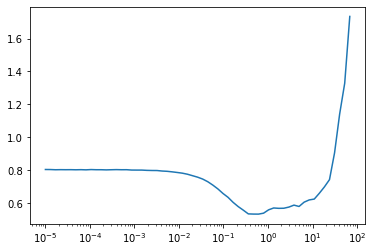

In [40]:
Learner(Autoenc(), dls, nn.BCEWithLogitsLoss(), cbs=[DeviceCB(), MixedPrecision()],
        opt_func=opt_func).lr_find()

In [41]:
lr = 3e-2
epochs=20
tmax=epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model=Autoenc()
learn=Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.723,0,train
0.631,0,eval


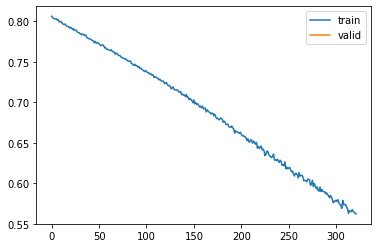

In [ ]:
# learn.fit(epochs)
# torch.save(learn.model, 'models/2024-01-24-vaesimple-usefhfe.pkl')

In [23]:
'''
junk model, but anyway, renamed to autoencsimple, it's not a vae
'''
model=torch.load('models/2024-01-24-vaesimple-usefhfe.pkl')

In [24]:
learn.model = model

loss,epoch,train
nan,0,eval


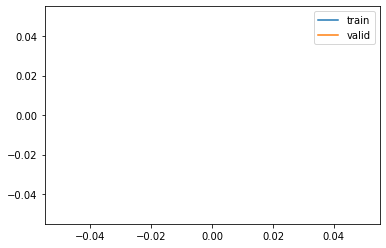

In [26]:
learn.fit(1, do_train=False, do_validate=True)

In [29]:
xb,_ = (next(iter(dls.train)))

loss,epoch,train
nan,0,eval


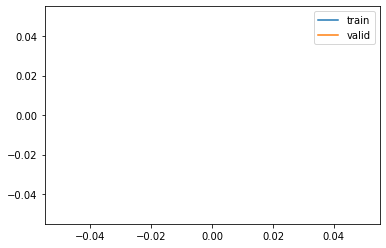

In [31]:
result=learn.capture_preds()


In [42]:
'''
try again. last model failed. didn't converge, nan loss, nan preds.

update: works great now, thanks
'''
lr = 3e-2
epochs=20
tmax=epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model=Autoenc()
learn=Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.528,0,train
0.465,0,eval
0.400,1,train
0.351,1,eval
0.316,2,train
0.305,2,eval
0.286,3,train
0.284,3,eval
0.276,4,train
0.277,4,eval


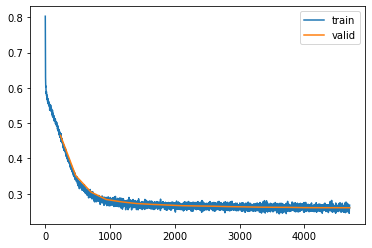

In [161]:
'''
note: renamed to autoencsimple-2. it's not a vae.
'''
learn.fit(epochs)
saveobj(learn.model, 'vaesimple-2')

loss,epoch,train
0.260,0,eval


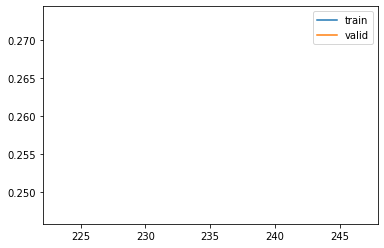

In [162]:
learn.fit(1, do_train=False, do_validate=True)

In [164]:
xb,_ = next(iter(dls.train))

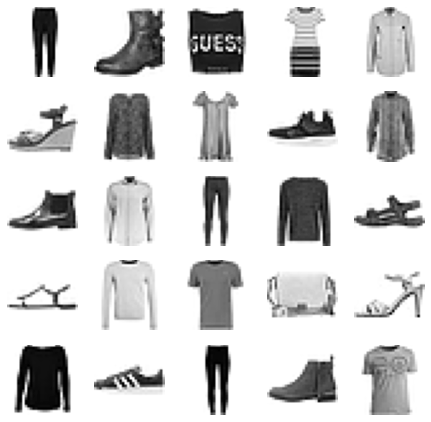

In [168]:
show_images(xb[:25].view(-1, 1, 28, 28), imsize=1.5)

Note: look how much better sigmoid is. Why is it so much better than the original output which was directly subjected to a BCE loss function?

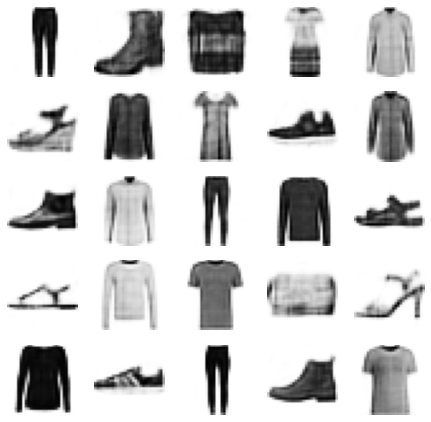

In [173]:
'''
sigmoid included
'''
show_images(learn.model(xb[:25].cuda()).view(-1, 1, 28, 28).sigmoid(), imsize=1.5)

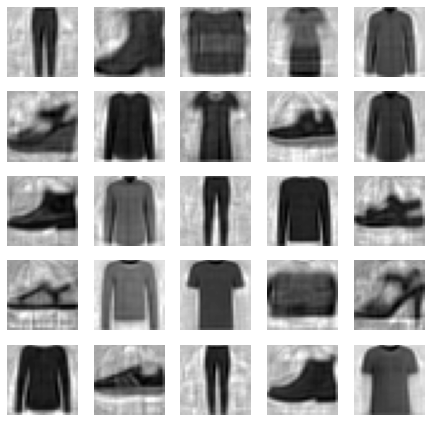

In [174]:
'''
no sigmoid
'''
show_images(learn.model(xb[:25].cuda()).view(-1, 1, 28, 28), imsize=1.5)

# VAE

In [99]:
s=nn.Sigmoid()

In [100]:
r =torch.randn((11,))
r,s(r)

(tensor([ 0.5106,  0.1419,  0.8089,  0.1196, -0.0864,  0.3022, -0.8421, -0.1157, -1.0821,  0.1785,  0.1007]),
 tensor([0.6250, 0.5354, 0.6919, 0.5299, 0.4784, 0.5750, 0.3011, 0.4711, 0.2531, 0.5445, 0.5252]))

In [92]:
def kdl_loss(inp, _):
    _, mu_x, lv_x = inp
    # var = (lv_x).exp()
    # return -0.5 * (1 + lv_x - mu_x**2 - var).mean()
    return -0.5 * (1 + lv_x - mu_x.pow(2) - lv_x.exp()).mean()

def bce_loss(inp, targets):
    return F.binary_cross_entropy_with_logits(inp[0], targets)

def vae_combined_loss(inp, act_x):
    return kdl_loss(inp, act_x) + bce_loss(inp, act_x)

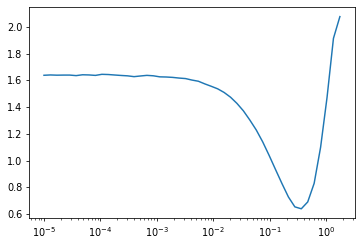

In [157]:
class VAE(nn.Module):
    def __init__(self):
        # remember to call init on module
        super().__init__()
        n_in=784
        n_hidden=400
        n_latents=144
        
        # enc: in to hidden
        self.enc = nn.Sequential(
            lin(n_in, n_hidden),
            lin(n_hidden, n_hidden),
        )

        # mu, lv: hidden to latent size
        self.mu = lin(n_hidden, n_latents, act=None)
        self.lv = lin(n_hidden, n_latents, act=None)

        # dec: latent back to in
        self.dec = nn.Sequential(
            lin(n_latents, n_hidden),
            lin(n_hidden, n_hidden),
            lin(n_hidden, n_in, act=None), # remember act=None for output layers
        )

        # remember to initialize weights
        # init_weights_partial(self)
        self.apply(init_weights_partial)
    def forward(self, x):
        x = self.enc(x)
        
        mu_x = self.mu(x)
        lv_x = self.lv(x)
        x = mu_x + (lv_x/2).exp() * torch.randn_like(mu_x)
        
        return self.dec(x), mu_x, lv_x # return mu, lv in order to run loss funcs incorporating them

Learner(VAE(), dls, vae_combined_loss, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

In [65]:
def mse(inp, targ):
    return F.mse_loss(inp[0], targ)

In [71]:
xb,yb=next(iter(dls.train))
xb.min(),xb.max()

(tensor(0.), tensor(1.))

kdl,bce,mse,loss,epoch,train
0.288,0.649,0.864,0.939,0,train
0.022,0.549,0.979,0.571,0,eval
0.003,0.517,1.655,0.520,1,train
0.000,0.500,2.397,0.500,1,eval
0.000,0.495,3.035,0.495,2,train
0.000,0.492,3.587,0.493,2,eval
0.000,0.491,4.035,0.491,3,train
0.000,0.491,4.380,0.492,3,eval
0.000,0.491,4.680,0.491,4,train
0.000,0.491,4.902,0.491,4,eval


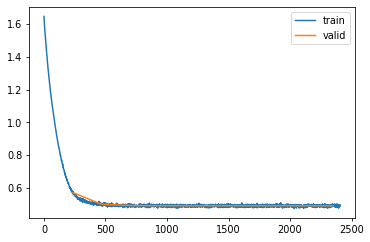

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [159]:
model = VAE()
lr = 1e-1
epochs=25
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
metrics=MetricsCB(kdl=FuncMetric(kdl_loss), bce=FuncMetric(bce_loss), mse=FuncMetric(mse))
cbs = [DeviceCB(), ActivationStats(), ProgressCB(plot=True), metrics, BatchSchedCB(sched), MixedPrecision()]
learn=Learner(model, dls, vae_combined_loss, cbs=cbs, opt_func=opt_func)

'''
final loss (196 latent dim, one less lin layer on both up and down)
0.341 	19 	eval
'''
learn.fit(epochs)

In [164]:
model.eval()
pb = model(xb.cuda())[0]

In [165]:
pb.min(),pb.max()

(tensor(-8.3672, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>),
 tensor(0.5635, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

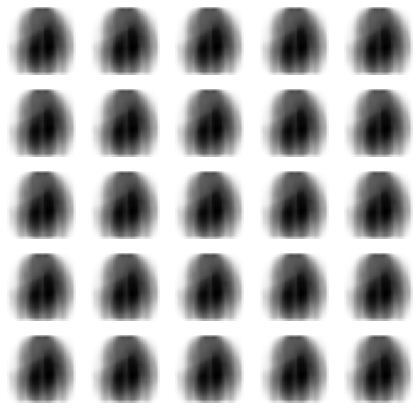

In [166]:
show_images(model(xb[:25].cuda())[0].sigmoid().view(25, 1, 28, 28).cpu(), imsize=1.5)

In [163]:
saveobj(learn.model, 'vae-144l')

In [53]:
class FuncMetric(Mean):
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn
    
    def update(self, inp, targets):
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [32]:
vae = torch.load('models/2024-01-28-vae-196l-4838ae36.pkl').cuda()

In [29]:
bs = 512
@inplace
def transformi(b):
    b['image'] = [TF.to_tensor(o).flatten() for o in b['image']]

transformed_ds = dsd.with_transform(transformi)

In [41]:
# dls = DataLoaders(dl(transformed_ds['train'], bs), dl(transformed_ds['test'], bs))
dls=DataLoaders(*get_dls(transformed_ds['train'], transformed_ds['test'], bs=bs, num_workers=fc.defaults.cpus, collate_fn=default_collate))
dls=DataLoaders.from_dd(transformed_ds, batch_size=bs)

In [43]:
xb,yb = next(iter(dls.valid))
xb.shape,yb.shape

(torch.Size([512, 784]), torch.Size([512]))

In [44]:
lats = []
labels=[]
for xb,yb in dls.train:
    encoded=vae.enc(xb.cuda())
    mux=vae.mu(encoded)
    lats.append(mux)
    labels.append(yb)

In [45]:
for xb,yb in dls.valid:
    encoded=vae.enc(xb.cuda())
    mux=vae.mu(encoded)
    lats.append(mux)
    labels.append(yb)

In [46]:
all_lats = torch.concat(lats).detach().cpu()
all_lats.shape

torch.Size([70000, 196])

In [47]:
all_lats = all_lats.view((-1, 1, 14, 14)).detach().cpu()
all_lats.shape

torch.Size([70000, 1, 14, 14])

In [48]:
lbls = torch.concat(labels)
lbls.shape

torch.Size([70000])

In [49]:
n_valid = len(all_lats) // 10

In [51]:
bs=512

In [52]:
tds = Dataset(all_lats[n_valid:], lbls[n_valid:])

In [53]:
vds = Dataset(all_lats[:n_valid], lbls[:n_valid])

In [14]:
def noisify_collate_class(batch):
    xb, class_b = default_collate(batch)
    (x_t, t), eps = noisify(xb)
    return (x_t, t, class_b), eps

In [55]:
lats_dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=noisify_collate_class))

In [57]:
(xt, t, c), eps = next(iter(lats_dls.train))
xt.shape, eps.shape, t.shape, c.shape, t[:5], c[:5]

(torch.Size([512, 1, 14, 14]),
 torch.Size([512, 1, 14, 14]),
 torch.Size([512]),
 torch.Size([512]),
 tensor([0.3587, 0.0932, 0.1188, 0.6683, 0.5171]),
 tensor([6, 4, 6, 6, 0]))

In [58]:
saveobj(lats_dls, 'dls-lats-labels-working')

In [8]:
'''
Idea is taken from original resnet paper which says that, "by construction" a decent solution to certain problems
could be to, when computing the residual r(x) as in y = r(x) + x, sometimes just to 0 out the residual so that the
whole layer would be an identity function. And so at least, that's a good starting point. Remember these resblocks
are "residual" blocks, so zero-ing out the second conv initializes the whole resblock to be the identity function
and gradient descent will learn a solution that evolves out of that point.
'''

def init_denoising_model(model):
    for blk in model.downblocks + model.upblocks:
        for r in blk.erbs:
            r.conv2[-1].weight.data.zero_()

In [96]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls_lats.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
'''
Almost forfot BatchSchedCB(sched) - takes in the scheduler callback and mutates LR in realtime
'''
cbs=[DeviceCB(), MixedPrecision(), MetricsCB(), ProgressCB(plot=True), BatchSchedCB(sched)]
model = EmbUNetModel(in_channels=1, out_channels=1, block_channel_counts=(64, 128), num_layers=2, attn_start=1, channels_per_head=16)
init_denoising_model(model)

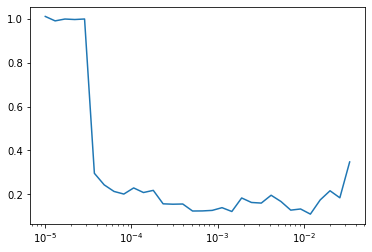

In [97]:
Learner(model, lats_dls, loss_func=nn.MSELoss(), lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

loss,epoch,train
0.043,0,train
0.031,0,eval
0.023,1,train
0.039,1,eval
0.018,2,train
0.018,2,eval
0.016,3,train
0.047,3,eval
0.013,4,train
0.018,4,eval


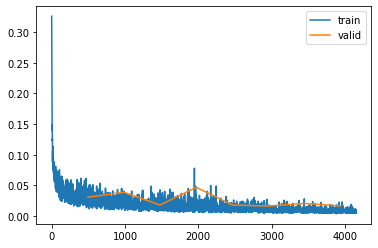

In [ ]:
lr = 3e-3
learn = Learner(model, dls_lats, loss_func=nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
saveobj(learn.model.state_dict(), 'fmnist-latent-diff-statedict-fixtrainval')

In [31]:
res = sample(ddim_step, learn.model, (49, 1, 14, 14), 100)

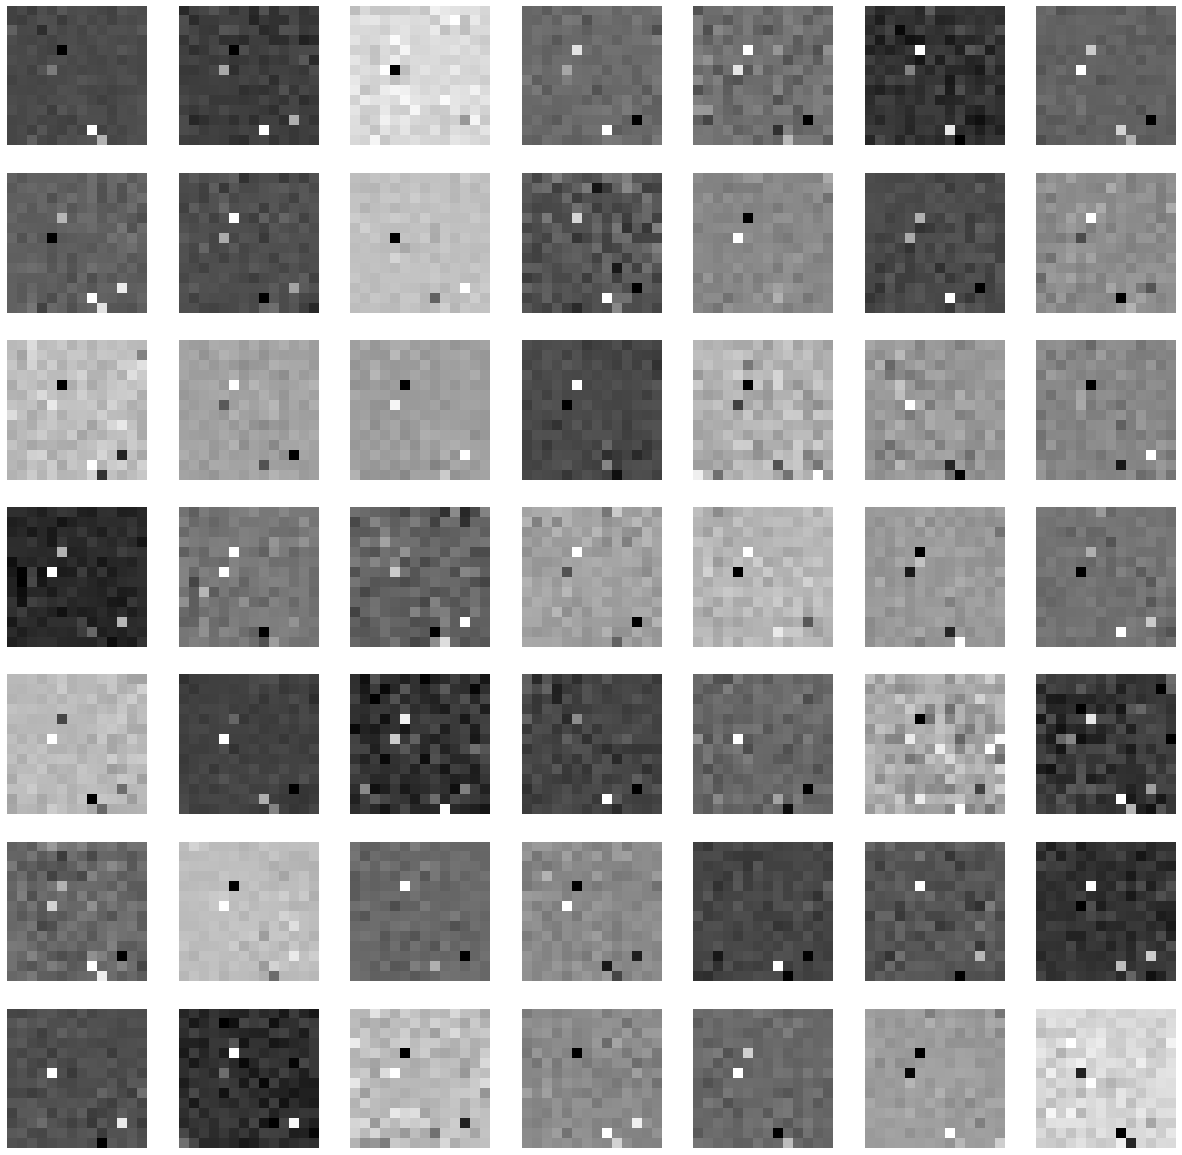

In [33]:
show_images(res.cpu())

In [36]:
vae=vae.cuda()

In [40]:
flat_lats = res.view(-1, 14**2).cuda()
flat_lats.shape, flat_lats.device

(torch.Size([49, 196]), device(type='cuda', index=0))

In [41]:
decoded = vae.dec(flat_lats)

In [43]:
decoded_ims = decoded.view(-1, 1, 28, 28).cpu()

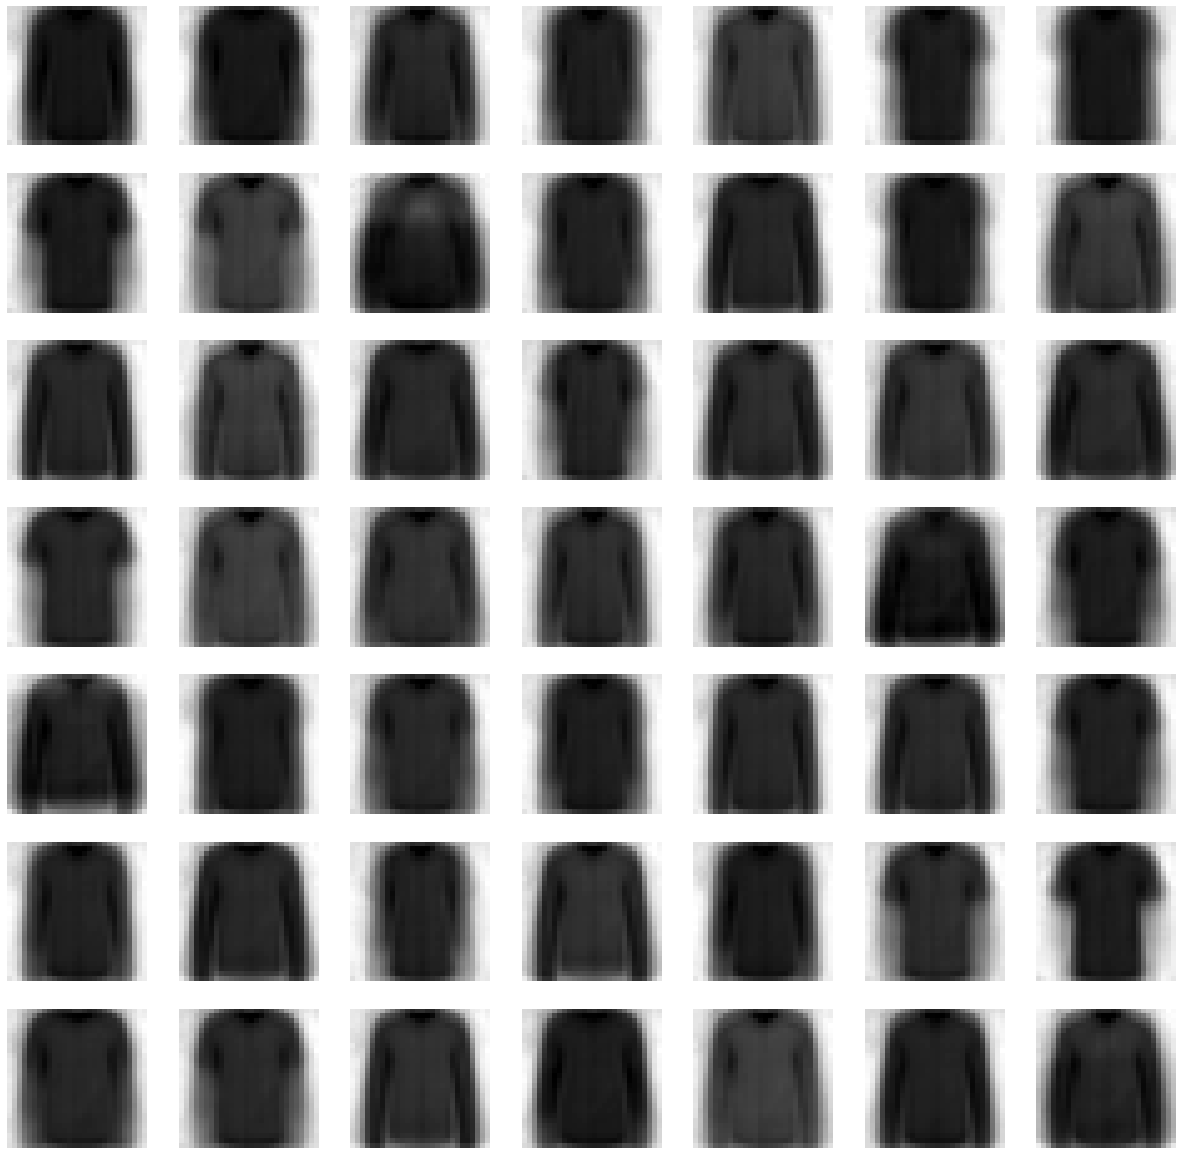

In [45]:
show_images(decoded_ims)

# Now with class conditioning

In [15]:
lats_dls=torch.load('models/2024-01-28-dls-lats-labels-working-4ebff66a.pkl')

In [22]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(lats_dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
'''
Almost forfot BatchSchedCB(sched) - takes in the scheduler callback and mutates LR in realtime
'''
cbs=[DeviceCB(), MixedPrecision(), MetricsCB(), ProgressCB(plot=True), BatchSchedCB(sched)]
model = CondEmbUNetModel(10, in_channels=1, out_channels=1, block_channel_counts=(32, 64), num_layers=2, attn_start=1, channels_per_head=16)
model.apply(init_weights_partial)
init_denoising_model(model)

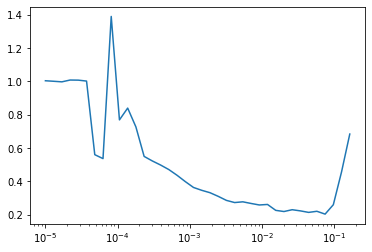

In [21]:
Learner(model, lats_dls, loss_func=nn.MSELoss(), lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

loss,epoch,train
0.340,0,train
0.173,0,eval
0.125,1,train
0.152,1,eval
0.073,2,train
0.076,2,eval
0.047,3,train
0.048,3,eval
0.036,4,train
0.041,4,eval


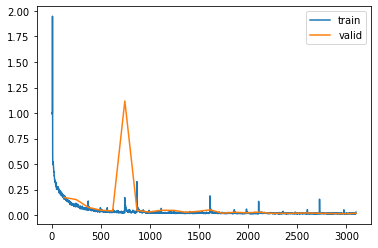

In [23]:
lr = 3e-3
learn = Learner(model, lats_dls, loss_func=nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [24]:
saveobj(learn.model.state_dict(), 'fmnist-condlatentdiff-statedict')

In [42]:
list(enumerate(dsd['test'].features['label'].names))

[(0, 'T - shirt / top'),
 (1, 'Trouser'),
 (2, 'Pullover'),
 (3, 'Dress'),
 (4, 'Coat'),
 (5, 'Sandal'),
 (6, 'Shirt'),
 (7, 'Sneaker'),
 (8, 'Bag'),
 (9, 'Ankle boot')]

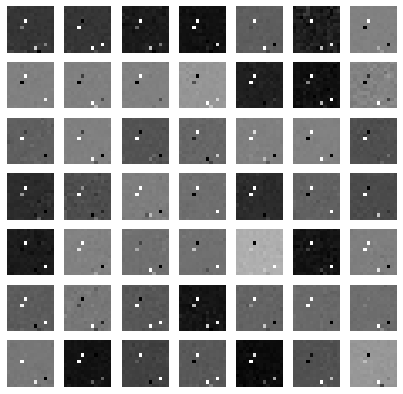

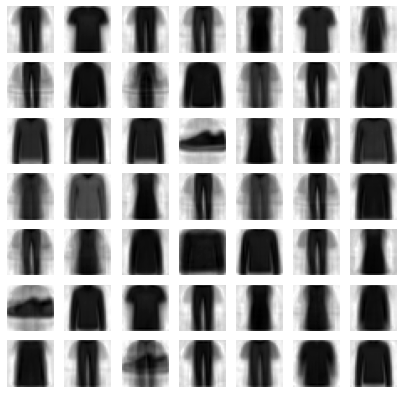

In [43]:
res = cond_sample(1, ddim_step, learn.model, (49, 1, 14, 14), 100)
show_images(res.cpu(), imsize=1.)
flat_lats = res.view(-1, 14**2).cuda()
flat_lats.shape, flat_lats.device
decoded = vae.dec(flat_lats)
decoded_ims = decoded.view(-1, 1, 28, 28).cpu()
show_images(decoded_ims, imsize=1)

In [36]:
res = cond_sample(2, ddim_step, learn.model, (49, 1, 14, 14), 100)
show_images(res.cpu(), imsize=1.)
flat_lats = res.view(-1, 14**2).cuda()
flat_lats.shape, flat_lats.device
decoded = vae.dec(flat_lats)
decoded_ims = decoded.view(-1, 1, 28, 28).cpu()
show_images(decoded_ims, imsize=1)

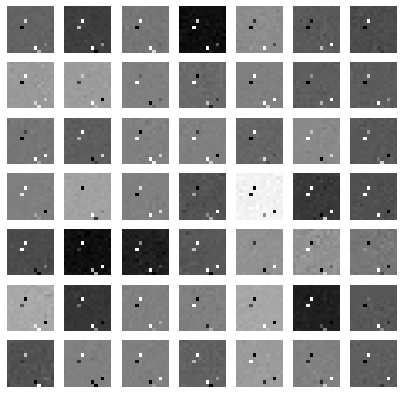

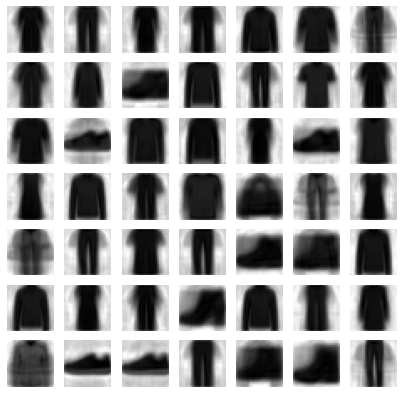

In [44]:
res = cond_sample(3, ddim_step, learn.model, (49, 1, 14, 14), 100)
show_images(res.cpu(), imsize=1.)
flat_lats = res.view(-1, 14**2).cuda()
flat_lats.shape, flat_lats.device
decoded = vae.dec(flat_lats)
decoded_ims = decoded.view(-1, 1, 28, 28).cpu()
show_images(decoded_ims, imsize=1)

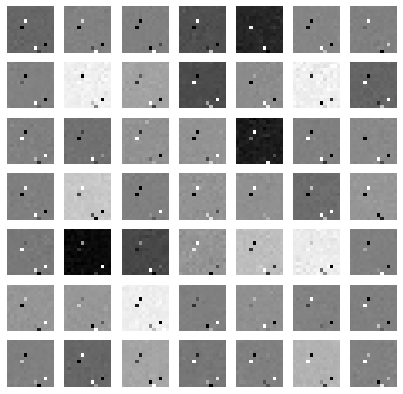

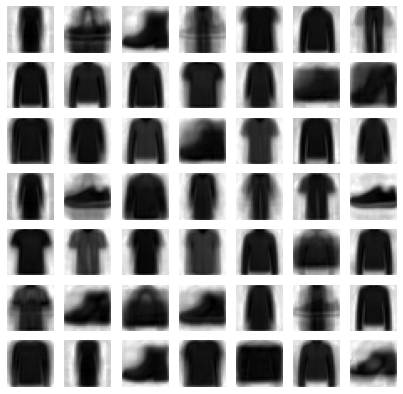

In [45]:
res = cond_sample(4, ddim_step, learn.model, (49, 1, 14, 14), 100)
show_images(res.cpu(), imsize=1.)
flat_lats = res.view(-1, 14**2).cuda()
flat_lats.shape, flat_lats.device
decoded = vae.dec(flat_lats)
decoded_ims = decoded.view(-1, 1, 28, 28).cpu()
show_images(decoded_ims, imsize=1)